In [38]:
%matplotlib inline
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from ipywidgets import FloatProgress
from IPython.display import display
from time import sleep

def initialCondition(m,n,volume_percent):
    if((volume_percent>=0.) & (volume_percent<=1.0)):
        system = np.random.random(size=(m,n)) 
        new_sys=np.copy(system)
        new_sys[system<=volume_percent] = 1
        new_sys[system>volume_percent]= -1
    else:
        print("Debug assertion: volume_percent for function initialCondition shoud be between 0 and 1")
    return new_sys

def energy(system,j=1):
    e = 0
    m = len(system) # rows
    n = len(system[0]) # columns
    for x in range(m):
        for y in range(n):
            s = system[x,y] # get the spin at current location
            e += -j*(s*(system[(x-1)%m,y]+system[(x+1)%m,y]+system[x,(y-1)%n]+system[x,(y+1)%n])) # -j*sum(s_i*s_j)       
    return e

def neigh_e(system,j,x,y):
    energy=0
    m = len(system) # row
    n = len(system[0]) # column
    s = system[x,y] # get the spin at current location
    energy = -j*(s*(system[(x-1)%m,y]+system[(x+1)%m,y]+system[x,(y-1)%n]+system[x,(y+1)%n]))
    return energy

def calc_de(old_system,new_system,j,x1,y1,x2,y2):
    de=0
    e1_old = neigh_e(old_system,j,x1,y1)
    e2_old = neigh_e(old_system,j,x2,y2)
    e1_new = neigh_e(new_system,j,x1,y1)
    e2_new = neigh_e(new_system,j,x2,y2)
    de1 = e1_new-e1_old
    de2 = e2_new-e2_old
    de = de1+de2
    return de
  
def trial_move(s,j,maximumJumpPercent): #randomly swap two positions in the system
    if((maximumJumpPercent>=0) & (maximumJumpPercent<=1)):
        temp = np.copy(s) # copy system
        m = len(temp) # row
        n = len(temp[0]) # column
        maximumJumpDistance = m*maximumJumpPercent
        
        x1 = np.random.randint(0, m) # get random position1 x coordinate
        y1 = np.random.randint(0, n) # get random position1 y coordinate
        x2 = x1 +int(maximumJumpDistance*(np.random.rand()-0.5))
        #print('x1: {},x2: {}'.format(x1,x2))
        x2 = x2%n
        y2 = y1 + int(maximumJumpDistance*(np.random.rand()-0.5))
        y2 = y2%m
        #print('y1: {},y2: {}'.format(y1,y2))
        temp[x2,y2], temp[x1,y1] = temp[x1,y1],temp[x2,y2]
        de = calc_de(s,temp,j,x1,y1,x2,y2)
    else:
        print("Debug assertion: maximumJumpPercent for function trial_move shoud be between 0 and 1")
    return temp,de

def accept(de,kT): #implement detailed balance
    if np.exp(-de/kT) > np.random.rand():
        return True
    return False

def run(kT,timeSteps,systemSize=10,j=1,volume_percent=0.1,maximumJumpPercent=0.1,saveMovie=False,showProgress=False): #specify temperature, number of steps to perform simulation
    e = []
    ims = []
    avgE = []
    stdDE = []
    steps = timeSteps[-1]
    
    system = initialCondition(systemSize,systemSize,volume_percent) #initialize 1's  and -1's randomly as it would at a high temperature
    if(saveMovie==True):
        fig = plt.figure(100)
        ax=fig.add_subplot(1,1,1)  
        im = plt.imshow(system, animated=True, axes=ax)
        ims.append([im])
    if(showProgress==True):
        f = FloatProgress(min=1, max=steps)
        display(f)
    systemEnergy = energy(system)
    #print('Intial System energy:{}'.format(systemEnergy))
    e.append(systemEnergy)
    for trials in range(1,int(steps)+1):
        trial,de = trial_move(system,j,maximumJumpPercent)
        #de = energy(trial,j)-energy(system,j)
        if accept(de,kT):
            system = np.copy(trial)
            systemEnergy+=de
        
        e.append(systemEnergy)
        if(trials in timeSteps.astype(int)):
            if(saveMovie==True):
                im = plt.imshow(system, animated=True,axes=ax, rasterized=True)#,cmap='gist_gray_r')
                ims.append([im])
            avgE.append(np.mean(e))
            stdDE.append(np.std(e)) 
            if(showProgress==True):
                sleep(0.1)
                f.value = trials
            
    #print('Final System energy:{}'.format(systemEnergy))
    saveImage=False
    if(saveImage):
        im = plt.imshow(system, animated=True, rasterized=True)#,cmap='gist_gray_r')
        plt.imsave(arr=im, fname='image_kT_{}_steps_{}_system_{}.png'.format(kT,steps,systemSize))
    if(saveMovie==True):
        ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
        ani.save('animation_kT_{}_steps_{}_system_{}.mp4'.format(kT,steps,systemSize))
        
    
    return kT,np.mean(e), np.std(e), system,avgE,stdDE #Return the temperature, average energy, and standard deviation

### Monte Carlo Project##

### Q1.	Pick a physical system you’re curious about, with the constraint that the interaction energy between system components must be non-zero or non-infinite for at least one interaction distance. ###

The physical system chosen is the Ostwald Ripening phenomenon.

*Title: 2D Ostwald Ripening simulation*

This is a phenomenon observed in solid solutions and liquid solutions where the grain size distribution of the solute narrows down. This occurs when grains of a certain critical size starts growing while grains below the critical size starts dissolving into the solution and redeposits on the larger grains. This technique allows the growth of crystals with a homogenous size distribution. 

Question that can be answered:

* Is the domain size (R) a function of time and agrees with R(t) ~ t^{1/3}?
* What is the critical radius for point particles and for an x shaped molecule?

### Q2.	Determine a simple (or, as simple as possible) representation of it that balances ease of implementation with probing its thermodynamics (If you’re struggling for ideas, I recommend looking at the 2D version of the example system from HW 2, or 3D Lennard-Jones spheres.) ###

Approach towards problem:

* Consider an alloy with two phases where the phenomenon is expected to be observed.
* The Ising model has been known to model ferromagnetic behaviour of materials primarily. But this model has also applications in phase seperation of alloys.
* The phase seperation problem in alloys can first be studied using the Ising model before approaching the Oswald ripening problem since this the phase seperation problem can directly use the Ising model.

The Ising model has been chosen to represent a two component mixture consisting of component A and component B. Here energy is calculated using 

$$ E = -J \sum_{i,j}{s_is_j} $$

Where J is the interaction energy (assumed a value of 1 as of now for all particles-particle interactions) and the sum represents sum over all the 4 nearest neighbours in the 2D lattice.

A 20x20 2D on-lattice Ising Model of a 50 vol% A and 50 vol% B mixture is considered to begin with.

#### Ising model for phase seperation ###

Psuedo code

* Intialize an 20x20 lattice with a 50-50 vol fraction of component A and B and random distribution which is equivalent to a very high temperature.
* Calculate the initial energy of the lattice
* Randomly pick two positions on the lattice and switch them.
* Calculate the change in energy using the two local energy changes and add them to obtain the total energy change
* Use the energy change to calculate the acceptance probability
* Accept or reject the new configuration

### Q3. Contrast your system with an ideal gas: ###
#### a.	Describe the 2-particle partition function
#### b.	Describe the many-particle partition function
#### c.	Determine (if possible) an equation of state for your system, or the appearance of any “phase transitions”.

As seen below, there seems to be phase transition at ~1 kT


maximum jump distace = 20
volume percent = 0.5
kT= [1.5]


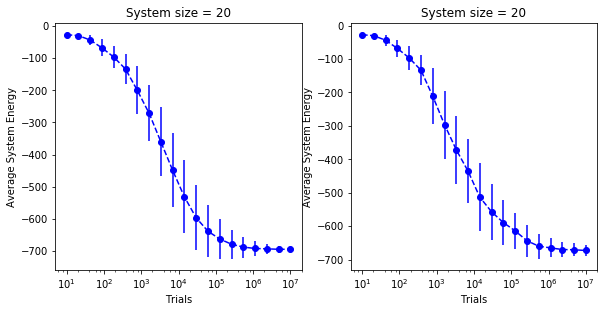

In [44]:
import numpy as np
import io
import base64
from IPython.display import HTML

timeStepsToLog = np.logspace(1,7,20)
kTs = [0.5,1.5]#np.logspace(-3,2,2)
j=1
vol_percent=0.5
systemSize=20
maxJumpDistancePerc = 1 #no restriction on maximum jump distance

print('maximum jump distace = {}'.format(maxJumpDistancePerc*systemSize))
print('volume percent = {}'.format(vol_percent))
print('kT= {}'.format(kT))

f = FloatProgress(min=systemSizes[0], max=systemSizes[-1])
display(f)

pltId=231
for kT in kTs:
    np.random.seed(1234567)
    t,avEnergy,stdDev,system,avgE,stdDE = run(kT,timeStepsToLog,systemSize,j,vol_percent,maxJumpDistancePerc)
    
    plt.figure(3,figsize=(15, 10))
    plt.subplot(pltId)
    plt.title('System size = {}'.format(round(systemSize,2)))
    ax = plt.gca()
    ax.relim()
    ax.autoscale_view()
    #plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.xlabel("Trials")
    plt.ylabel("Average System Energy")
    plt.errorbar(timeStepsToLog,avgE,stdDE,linestyle='--', marker='o', color='b')
    
    sleep(0.1)
    f.value = systemSize
    pltId+=1

[0.5]


<Container object of 3 artists>

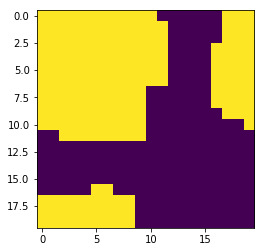

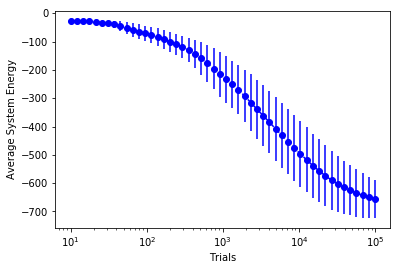

In [42]:
import numpy as np
import io
import base64
from IPython.display import HTML

timeStepsToLog = np.logspace(1,5,50)
kT = [0.5]#np.logspace(-3,2,2)
j=1
vol_percent=0.5 #50 vol% of A(represented by 1)
maxJumpDistancePerc = 1 #no restriction on maximum jump distance
print(kT)
systemSize=20
np.random.seed(1234567)
t,avEnergy,stdDev,system,avgE,stdDE = run(kT,timeStepsToLog,systemSize,j,vol_percent,maxJumpDistancePerc,saveMovie=True,showProgress=True)

video = io.open('animation_kT_{}_steps_{}_system_{}.mp4'.format(kT,timeStepsToLog[-1],systemSize), 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

plt.figure()
ax = plt.gca()
ax.relim()
ax.autoscale_view()
#plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel("Trials")
plt.ylabel("Average System Energy")
plt.errorbar(timeStepsToLog,avgE,stdDE,linestyle='--', marker='o', color='b')

kTs= [ 0.1         0.30526316  0.51052632  0.71578947  0.92105263  1.12631579
  1.33157895  1.53684211  1.74210526  1.94736842  2.15263158  2.35789474
  2.56315789  2.76842105  2.97368421  3.17894737  3.38421053  3.58947368
  3.79473684  4.        ]


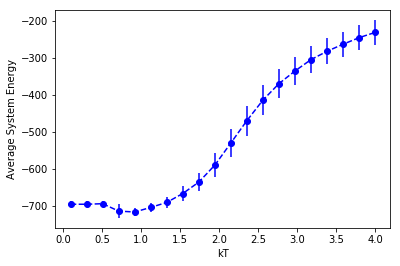

In [21]:
import numpy as np
import io
import base64
from IPython.display import HTML

timeStepsToLog = np.logspace(7,7,1)
kTs = np.linspace(0.1,4,20)
j=1
vol_percent = 0.5
systemSize=20
maxJumpDistancePerc = 1 #no restriction on maximum jump distance

print('kTs= {}'.format(kTs))

avgEs = []
stdDEs = []
f = FloatProgress(min=kTs[0], max=kTs[-1])
display(f)
for kT in kTs:
    np.random.seed(1234567)
    t,avEnergy,stdDev,dummy,dummy,dummy = run(kT,timeStepsToLog,systemSize,j,vol_percent,maxJumpDistancePerc)
    avgEs.append(avEnergy)
    stdDEs.append(stdDev)
    sleep(0.1)
    f.value = kT
    
plt.figure()
ax = plt.gca()
ax.relim()
ax.autoscale_view()
#plt.gca().invert_yaxis()
#plt.xscale('log')
plt.xlabel("kT")
plt.ylabel("Average System Energy")
plt.errorbar(kTs,avgEs,stdDEs,linestyle='--', marker='o', color='b')
DataOut = np.column_stack((kTs,avgEs,stdDEs))
np.savetxt('kTPlot.dat',DataOut,newline='\n')

kTs= [  1.00000000e-03   1.83298071e-03   3.35981829e-03   6.15848211e-03
   1.12883789e-02   2.06913808e-02   3.79269019e-02   6.95192796e-02
   1.27427499e-01   2.33572147e-01   4.28133240e-01   7.84759970e-01
   1.43844989e+00   2.63665090e+00   4.83293024e+00   8.85866790e+00
   1.62377674e+01   2.97635144e+01   5.45559478e+01   1.00000000e+02]


/Users/stephenthomas/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:70: RuntimeWarning: overflow encountered in exp


<Container object of 3 artists>

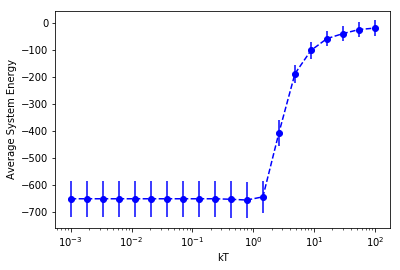

In [2]:
import numpy as np
import io
import base64
from IPython.display import HTML

timeStepsToLog = np.logspace(5,5,1)
kTs = np.logspace(-3,2,20)
j=1
vol_percent = 0.5
systemSize=20
maxJumpDistancePerc = 1 #no restriction on maximum jump distance

print('kTs= {}'.format(kTs))

avgEs = []
stdDEs = []
f = FloatProgress(min=kTs[0], max=kTs[-1])
display(f)
for kT in kTs:
    np.random.seed(1234567)
    t,avEnergy,stdDev,dummy,dummy,dummy = run(kT,timeStepsToLog,systemSize,j,vol_percent,maxJumpDistancePerc)
    avgEs.append(avEnergy)
    stdDEs.append(stdDev)
    sleep(0.1)
    f.value = kT
    
plt.figure()
ax = plt.gca()
ax.relim()
ax.autoscale_view()
#plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel("kT")
plt.ylabel("Average System Energy")
plt.errorbar(kTs,avgEs,stdDEs,linestyle='--', marker='o', color='b')

From literature (), it can be seen that the critical temperature is given by 

### Q4. Characterize your model’s performance: ###
#### a.	How long does it take to equilibrate?

Since the solid phase is observed below 1 kT, time to equilibriation is studied at 0.5 kT. In the below figure, the average energy is plotted as a function of trials. The average energy appears to converge at ~1e6 trials.

[0.5]


<Container object of 3 artists>

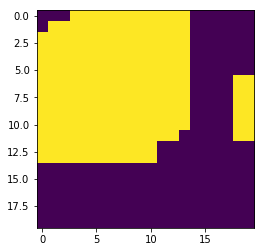

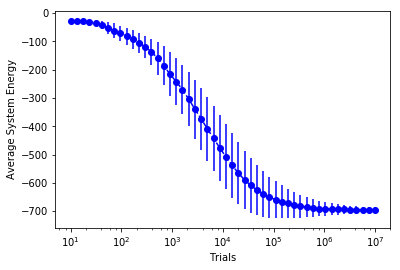

In [3]:
import numpy as np
import io
import base64
from IPython.display import HTML

timeStepsToLog = np.logspace(1,7,50)
kT = [0.5]#np.logspace(-3,2,2)
j=1
vol_percent=0.5 #50 vol% of A(represented by 1)
maxJumpDistancePerc = 1 #no restriction on maximum jump distance
print(kT)
systemSize=20
np.random.seed(1234567)
t,avEnergy,stdDev,system,avgE,stdDE = run(kT,timeStepsToLog,systemSize,j,vol_percent,maxJumpDistancePerc,saveMovie=True,showProgress=True)

video = io.open('animation_kT_{}_steps_{}_system_{}.mp4'.format(kT,timeStepsToLog[-1],systemSize), 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

plt.figure()
ax = plt.gca()
ax.relim()
ax.autoscale_view()
#plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel("Trials")
plt.ylabel("Average System Energy")
plt.errorbar(timeStepsToLog,avgE,stdDE,linestyle='--', marker='o', color='b')

#### b.	How small is too small? How big is too big?

From the below figures, it can be seen that for system sizes below 4, the energy does not vary with trials. So systems smaller than 4x4 are too small.

maximum jump distace = 20
volume percent = 0.5
kT= [0.5]


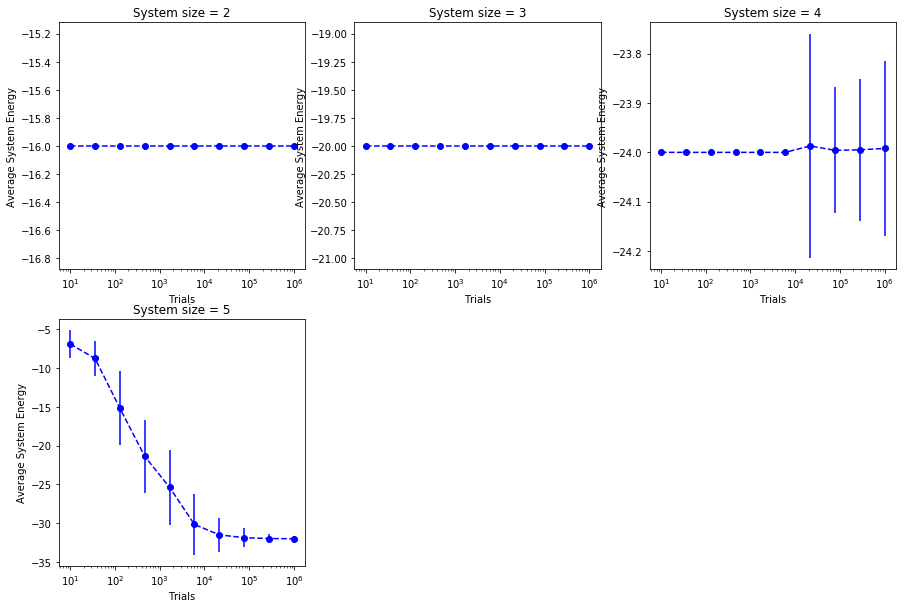

In [4]:
import numpy as np
import io
import base64
from IPython.display import HTML

timeStepsToLog = np.logspace(1,6,10)
kT = [0.5]#np.logspace(-3,2,2)
j=1
vol_percent=0.5
systemSizes=range(2,6)
maxJumpDistancePerc = 1 #no restriction on maximum jump distance

print('maximum jump distace = {}'.format(maxJumpDistancePerc*systemSize))
print('volume percent = {}'.format(vol_percent))
print('kT= {}'.format(kT))

f = FloatProgress(min=systemSizes[0], max=systemSizes[-1])
display(f)

pltId=231
for systemSize in systemSizes:
    np.random.seed(1234567)
    t,avEnergy,stdDev,system,avgE,stdDE = run(kT,timeStepsToLog,systemSize,j,vol_percent,maxJumpDistancePerc)
    
    plt.figure(3,figsize=(15, 10))
    plt.subplot(pltId)
    plt.title('System size = {}'.format(round(systemSize,2)))
    ax = plt.gca()
    ax.relim()
    ax.autoscale_view()
    #plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.xlabel("Trials")
    plt.ylabel("Average System Energy")
    plt.errorbar(timeStepsToLog,avgE,stdDE,linestyle='--', marker='o', color='b')
    
    sleep(0.1)
    f.value = systemSize
    pltId+=1

There are two considerations for determining how big is too big for system sizes.
* Time to compute energy
* Time to equilibriate energy

The current algorithm calculates the change in energy of the system between two states, by just calculating the local change in energy. Since the local change in energy depends only on the nearest neighbours of the two sites which are interchanged, the time to compute energy is independent of the total system size.

However, time to equilibriate energy might depend on system size. Different system sizes are explored below:

maximum jump distace = 5
volume percent = 0.5
kT= [0.5]


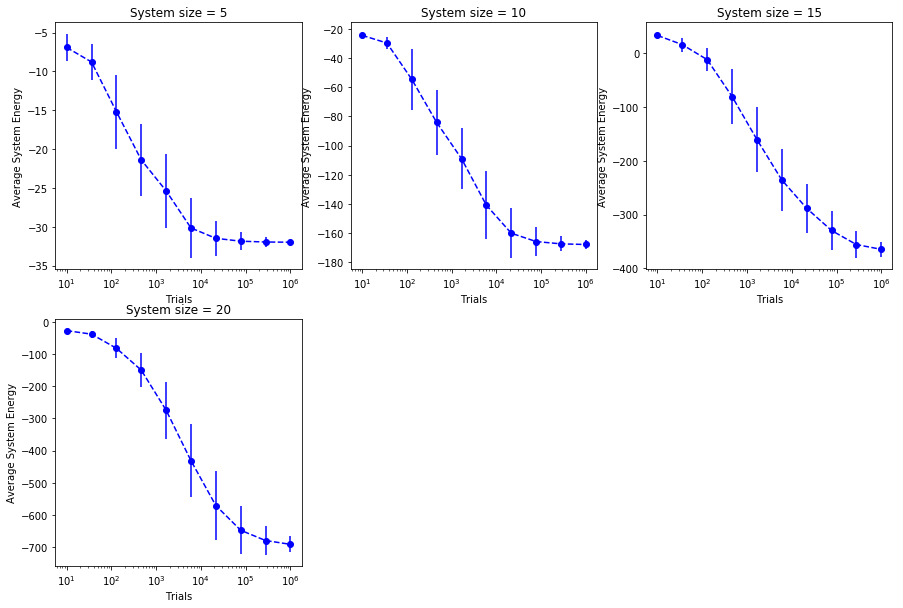

In [5]:
import numpy as np
import io
import base64
from IPython.display import HTML

timeStepsToLog = np.logspace(1,6,10)
kT = [0.5]#np.logspace(-3,2,2)
j=1
vol_percent=0.5
systemSizes=range(5,25,5)
maxJumpDistancePerc = 1 #no restriction on maximum jump distance

print('maximum jump distace = {}'.format(maxJumpDistancePerc*systemSize))
print('volume percent = {}'.format(vol_percent))
print('kT= {}'.format(kT))

f = FloatProgress(min=systemSizes[0], max=systemSizes[-1])
display(f)

pltId=231
for systemSize in systemSizes:
    np.random.seed(1234567)
    t,avEnergy,stdDev,system,avgE,stdDE = run(kT,timeStepsToLog,systemSize,j,vol_percent,maxJumpDistancePerc)
    
    plt.figure(3,figsize=(15, 10))
    plt.subplot(pltId)
    plt.title('System size = {}'.format(round(systemSize,2)))
    ax = plt.gca()
    ax.relim()
    ax.autoscale_view()
    #plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.xlabel("Trials")
    plt.ylabel("Average System Energy")
    plt.errorbar(timeStepsToLog,avgE,stdDE,linestyle='--', marker='o', color='b')
    
    sleep(0.1)
    f.value = systemSize
    pltId+=1

It can be observed that the system with size 5 approaches a steady state around 1.5e4 trials, whereas for the system with size 20, it has not reached steady state until 1e6 trials. In order to decide on the question "how big is too big", the considerations are as follow:

* How much computational time is considered acceptable?
* How large should the system be in order to study the Ostwald Ripening?

1e6 trials complete in under 5 minutes of computational time on a laptop. But 1e7 trials take close to an hour of computational time on a laptop which is considered acceptable. So, system sizes more than 20 is considered "too big".

#### c.	Can you improve the performance of your simulation by changing the trial moves?

Yes, by performing local energy change calculation instead of calculating energy of the entire system, the simulation performance is improved. With this approach, energy change calculation is independent of system size as can be observed in the code above.

### Q5.	What do the results of this model teach us about the world? ###

#### a.	What thermodynamic observables can you calculate? Are there any surprises here?

In the previous simulations, the particles were allowed to jump any distance within the simulation domain. This leads to the thermodynamic minimum energy configuration. The thermodynamic minimum energy state of the system below the phase transition point is a single particle. However, this only happens in the real world when the solid is allowed to equilibriate for a very long time. The current maximum jump distance cannot be used to simulate the Ostwald ripening phenomenon observed in real mixtures. 

One "observable" quantity is the number of clusters formed. 

#### b.	Are there any “structures” that form at any state points? Do these observations help us understand the physical system you’re modeling?

The Ostwald ripening process is a consequence of the kinetics of the system rather than an thermodynamic observable.  It is a diffusion limited process where the driving force is reduction of the interfacial energy. In order to simulate this kinetic process, it is necessary to limit the maximum jump distance. But before exploring the effect of varying the maximum jump distance, the effect of varying the composition of the solute and solvent is explored. The volume percent of component A is varied from 1% to 50% below:

maximum jump distace = 20
volume percents = [ 0.01   0.108  0.206  0.304  0.402  0.5  ]
kT= [0.5]


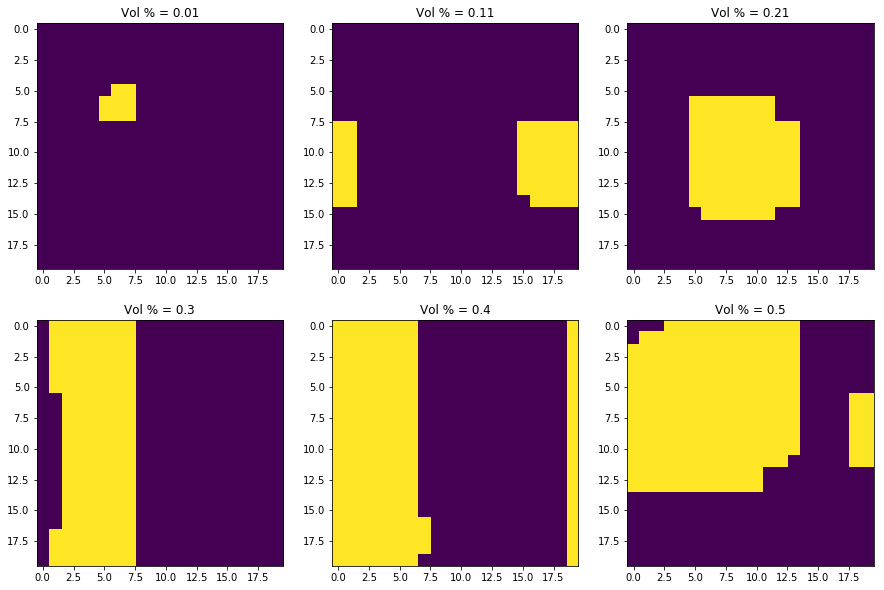

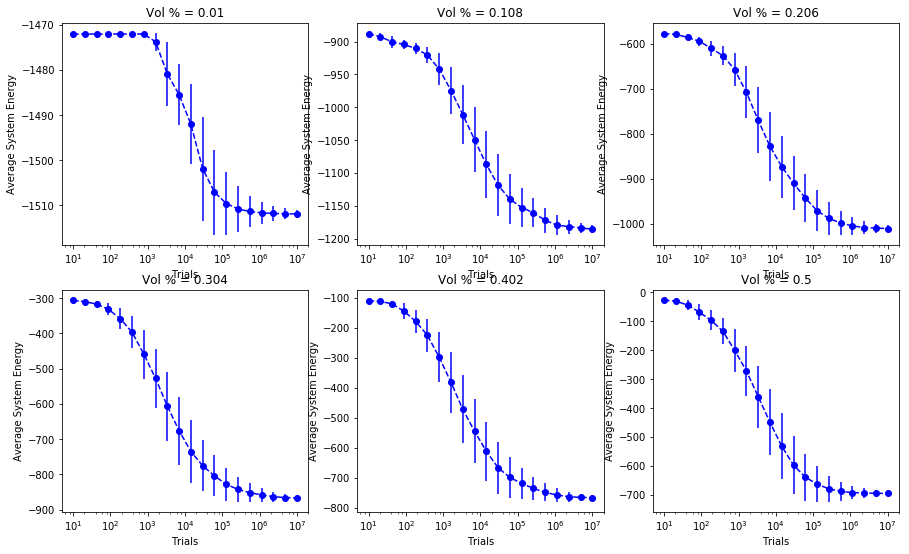

In [7]:
import numpy as np
import io
import base64
from IPython.display import HTML

timeStepsToLog = np.logspace(1,7,20)
kT = [0.5]#np.logspace(-3,2,2)
j=1
vol_percents= np.linspace(1e-2,0.5,6)
systemSize=20
maxJumpDistancePerc = 1 #no restriction on maximum jump distance

print('maximum jump distace = {}'.format(maxJumpDistancePerc*systemSize))
print('volume percents = {}'.format(vol_percents))
print('kT= {}'.format(kT))

f = FloatProgress(min=vol_percents[0], max=vol_percents[-1])
display(f)

pltId=231
for vol_percent in vol_percents:
    np.random.seed(1234567)
    t,avEnergy,stdDev,system,avgE,stdDE = run(kT,timeStepsToLog,systemSize,j,vol_percent,maxJumpDistancePerc)
    plt.figure(2,figsize=(15, 10))
    plt.subplot(pltId) 
    plt.title('Vol % = {}'.format(round(vol_percent,2)))
    im = plt.imshow(system, animated=True,rasterized=True)#,cmap='gist_gray_r')
    
    plt.figure(3,figsize=(15, 9))
    plt.subplot(pltId)
    plt.title('Vol % = {}'.format(round(vol_percent,3)))
    ax = plt.gca()
    ax.relim()
    ax.autoscale_view()
    #plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.xlabel("Trials")
    plt.ylabel("Average System Energy")
    plt.errorbar(timeStepsToLog,avgE,stdDE,linestyle='--', marker='o', color='b')
    
    sleep(0.1)
    f.value = vol_percent
    pltId+=1

In all the compositions, the final configuration is a single particle. So, varying the composition does not seem to help in simulating the Ostwald ripening process. However, with a lower volume fraction, the clusters could form at a larger distance from each other. The next experiment aims at studying the effect of maximum jump distance on the cluster formation using component A volume percent of 20%

The maximum jump distance is now varied from 5% to 25% of the box dimension.

maximum jump distaces = [ 1.00237447  2.24403691  5.02377286]
volume percents = 0.2
kT= [0.5]


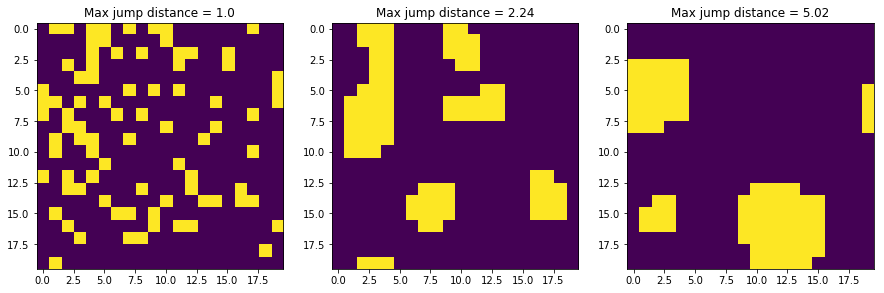

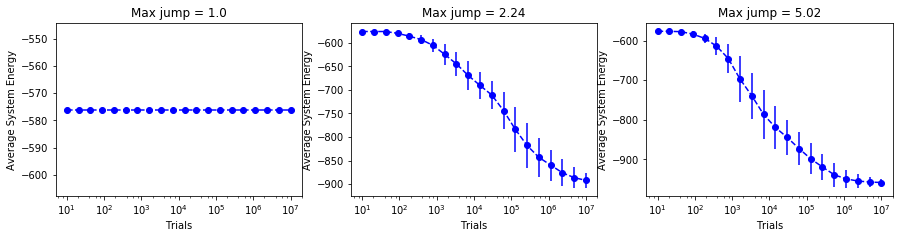

In [8]:
import numpy as np
import io
import base64
from IPython.display import HTML

timeStepsToLog = np.logspace(1,7,20)
kT = [0.5]#np.logspace(-3,2,2)
j=1
#vol_percents= np.arange(0.5,0.0,-0.1)
vol_percent=0.2
systemSize=20
maxJumpDistancePercs= np.logspace(-1.3,-0.6,3)#np.linspace(0.05,1,6)

print('maximum jump distaces = {}'.format(maxJumpDistancePercs*systemSize))
print('volume percents = {}'.format(vol_percent))
print('kT= {}'.format(kT))

f = FloatProgress(min=maxJumpDistancePercs[0], max=maxJumpDistancePercs[-1])
display(f)

pltId=231
for maxJumpDistancePerc in maxJumpDistancePercs:
    np.random.seed(1234567)
    t,avEnergy,stdDev,system,avgE,stdDE = run(kT,timeStepsToLog,systemSize,j,vol_percent,maxJumpDistancePerc)
    plt.figure(2,figsize=(15, 10))
    plt.subplot(pltId) 
    plt.title('Max jump distance = {}'.format(round(maxJumpDistancePerc*systemSize,2)))
    im = plt.imshow(system, animated=True,rasterized=True)#,cmap='gist_gray_r')
    
    plt.figure(3,figsize=(15, 7))
    plt.subplot(pltId)
    plt.title('Max jump = {}'.format(round(maxJumpDistancePerc*systemSize,2)))
    ax = plt.gca()
    ax.relim()
    ax.autoscale_view()
    #plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.xlabel("Trials")
    plt.ylabel("Average System Energy")
    plt.errorbar(timeStepsToLog,avgE,stdDE,linestyle='--', marker='o', color='b')
    sleep(0.1)
    f.value = maxJumpDistancePerc
    
    pltId+=1

The number of clusters reduce with increasing jump distance for the same amount of trials. There are 4 clusters in the left most case and just one cluster in the right most case when the periodic boundary condition is considered.

maximum jump distaces = [ 2.]
volume percents = 0.2
kT= [0.5]


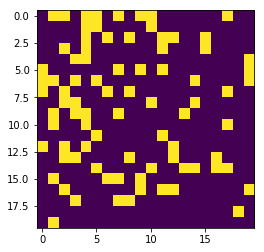

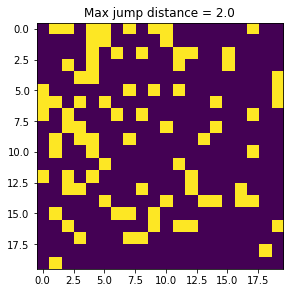

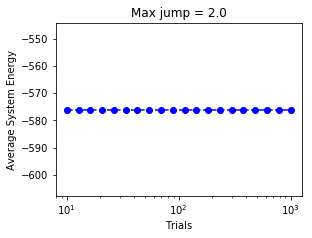

In [11]:
import numpy as np
import io
import base64
from IPython.display import HTML

timeStepsToLog = np.logspace(1,7,20)
kT = [0.5]#np.logspace(-3,2,2)
j=1
#vol_percents= np.arange(0.5,0.0,-0.1)
vol_percent=0.2
systemSize=20
maxJumpDistancePercs= np.logspace(-0.9,-0.9,1)#np.linspace(0.05,1,6)

print('maximum jump distaces = {}'.format(maxJumpDistancePercs*systemSize))
print('volume percents = {}'.format(vol_percent))
print('kT= {}'.format(kT))

#f = FloatProgress(min=maxJumpDistancePercs[0], max=maxJumpDistancePercs[-1])
#display(f)

pltId=231
for maxJumpDistancePerc in maxJumpDistancePercs:
    np.random.seed(1234567)
    t,avEnergy,stdDev,system,avgE,stdDE = run(kT,timeStepsToLog,systemSize,j,vol_percent,maxJumpDistancePerc,saveMovie=True,showProgress=True)
    plt.figure(2,figsize=(15, 10))
    plt.subplot(pltId) 
    plt.title('Max jump distance = {}'.format(round(maxJumpDistancePerc*systemSize,2)))
    im = plt.imshow(system, animated=True,rasterized=True)#,cmap='gist_gray_r')
    
    plt.figure(3,figsize=(15, 7))
    plt.subplot(pltId)
    plt.title('Max jump = {}'.format(round(maxJumpDistancePerc*systemSize,2)))
    ax = plt.gca()
    ax.relim()
    ax.autoscale_view()
    #plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.xlabel("Trials")
    plt.ylabel("Average System Energy")
    plt.errorbar(timeStepsToLog,avgE,stdDE,linestyle='--', marker='o', color='b')
    #sleep(0.1)
    #f.value = maxJumpDistancePerc
    
    pltId+=1

In [ ]:
video = io.open('animation_kT_{}_steps_{}_system_{}.mp4'.format([0.5],1e7,20), 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In the animation above, the coarsening of the smaller clusters can be observed.